In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import string
import nltk
import numpy as np


nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import os
import sys

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import NewsDataLoader

if __name__ == "__main__":
    data_directory = "../data"
    loader = NewsDataLoader(data_directory)

    merge_df = loader.load_data()
print(merge_df.columns)

Index(['article_id', 'source_name', 'author', 'title', 'description', 'url',
       'published_at', 'content', 'category', 'article', 'title_sentiment',
       'SourceCommonName', 'location', 'Country', 'GlobalRank', 'TldRank',
       'Domain', 'TLD', 'RefSubNets', 'RefIPs', 'IDN_Domain', 'IDN_TLD',
       'PrevGlobalRank', 'PrevTldRank', 'PrevRefSubNets', 'PrevRefIPs'],
      dtype='object')


In [5]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

merge_df['processed_title'] = merge_df['title'].apply(preprocess_text)
merge_df['processed_content'] = merge_df['content'].apply(preprocess_text)
merge_df['combined_text'] = merge_df['processed_title'] + ' ' + merge_df['processed_content']


In [6]:
categories = {
    'Breaking News',
    'Politics',
    'World News',
    'Business/Finance',
    'Technology',
    'Science',
    'Health',
    'Entertainment',
    'Sports',
    'Environment',
    'Crime',
    'Education',
    'Weather',
    'Other'
}


In [7]:

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(merge_df['combined_text'])

# Define number of topics
num_topics = 10

# Apply LDA for topic modeling
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)


LatentDirichletAllocation(random_state=42)

In [34]:
doc_topic_matrix = lda_model.transform(X)

# Assign topic categories based on dominant topics
def get_dominant_topic(topic_distribution):
    return np.argmax(topic_distribution)

topic_categories = {
    'Breaking News': [0, 1],
    'Politics': [2, 3],
    'World News': [4, 5],
    'Business/Finance': [6, 7],
    'Technology': [8, 9],
    'Science': [10,11],  # Add relevant topic indices
    'Health': [12,13],  # Add relevant topic indices
    'Entertainment': [14,15],  # Add relevant topic indices
    'Sports': [16,17],  # Add relevant topic indices
    'Environment': [18,19],  # Add relevant topic indices
    'Crime': [20,21],  # Add relevant topic indices
    'Education': [22,23],  # Add relevant topic indices
    'Weather': [24,25],  # Add relevant topic indices
    'Other': []  # Add relevant topic indices
}

# Function to categorize topics into predefined categories
def map_to_category(dominant_topic):
    if dominant_topic in range (0,2):
       return 'Breaking News'
    elif dominant_topic in range (2,4) :
       return 'Politics'
    elif dominant_topic in range (4,6):
       return 'World News'
    elif dominant_topic in range (6,8):
       return 'Business/Finance'
    elif dominant_topic in range (8,10):
       return 'Technology'
    elif dominant_topic in range (10,12):
       return 'Science'
    elif dominant_topic in range (12,14):
       return 'Health'
    elif dominant_topic in range (14,16):
       return 'Entertainment'
    elif dominant_topic in range (16,18):
       return 'Sports'
    elif dominant_topic in range (18,20):
       return 'Environment'
    elif dominant_topic in range (20,22):
       return 'Crime'
    elif dominant_topic in range (22,24):
       return 'Education'
    elif dominant_topic in range (24,26):
       return 'Weather'
    else:
        return 'Other'

dominant_topics = [get_dominant_topic(topic_dist) for topic_dist in doc_topic_matrix]
topic_categories = [map_to_category(topic) for topic in dominant_topics]
# Add the assigned topic categories to the DataFrame
merge_df['topic_category'] = topic_categories


In [37]:
# Calculate the diversity of topics covered by each website
website_topic_diversity = merge_df.groupby('source_name')['topic_category'].nunique().reset_index()
website_topic_diversity.columns = ['source_name', 'topic_diversity']

# Find the website with the highest topic diversity
most_diverse_website = website_topic_diversity.loc[website_topic_diversity['topic_diversity'].idxmax()]

# Print the most diverse website
print("Website with the highest topic diversity:", most_diverse_website['source_name'])
print("Number of unique topics covered:", most_diverse_website['topic_diversity'])
print("Top 10 website with diverse topics:", website_topic_diversity.head(10))  

Website with the highest topic diversity: ABC News
Number of unique topics covered: 5
                   source_name  topic_diversity
0                     ABC News                5
1           Al Jazeera English                5
2  AllAfrica - Top Africa News                3
3              Android Central                5
4                     BBC News                5
5                  Boing Boing                5
6             Business Insider                5
7                          CNN                5
8                     Deadline                5
9               Digital Trends                4


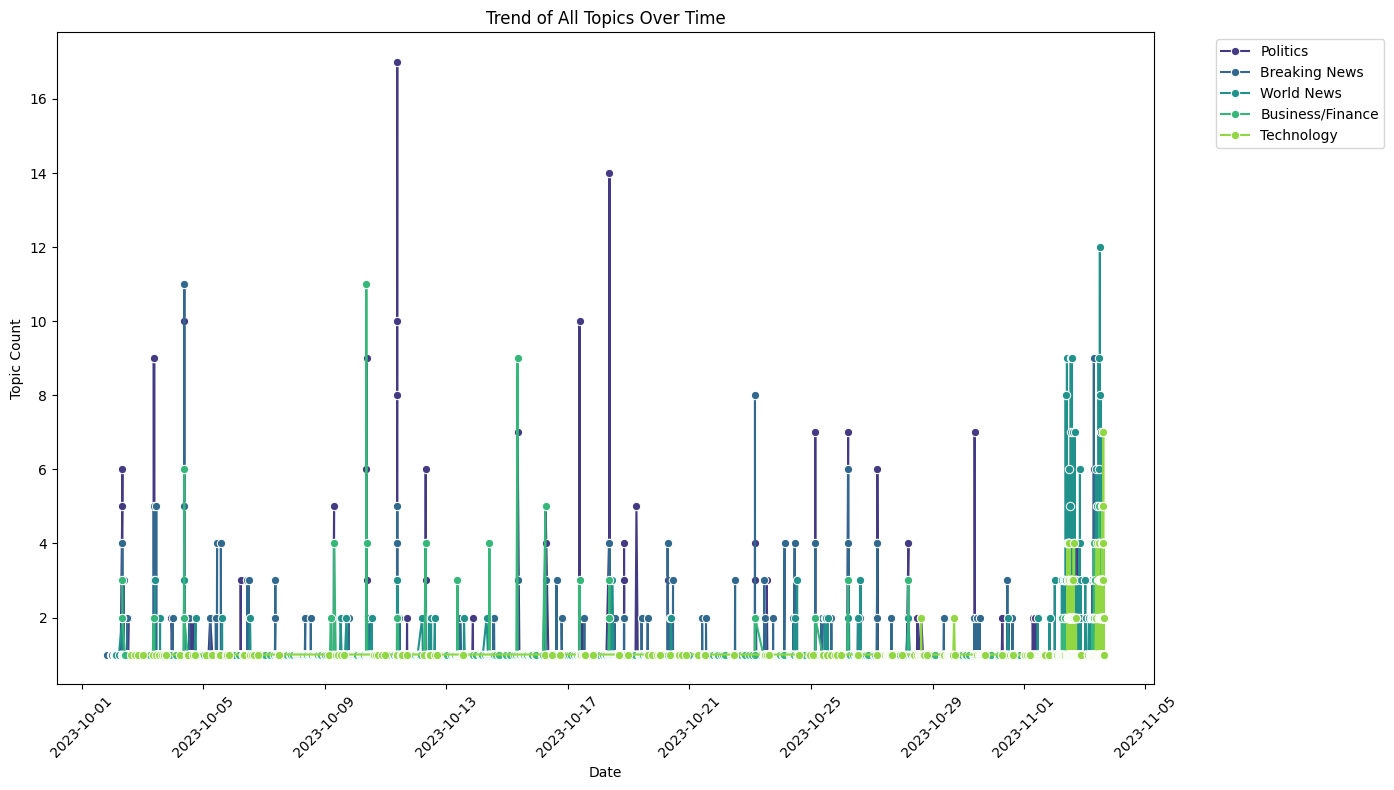

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the trend of all topics over time
plt.figure(figsize=(12, 8))
sns.lineplot(data=topic_trend, x='published_at', y='topic_count', hue='topic_category', palette='viridis', marker='o')
plt.xlabel('Date')
plt.ylabel('Topic Count')
plt.title('Trend of All Topics Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
